In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import sklearn.linear_model
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import scipy.optimize as sp
from scipy.optimize import minimize
from scipy.special import expit  # sigmoid

In [23]:

# Open the CSV and read all rows as lists of strings
with open("DFT_Data - Input.csv", 'r') as x:
    data = list(csv.reader(x, delimiter=","))

# Deletes title row
data = data[1:]

# Remove empty string entries from each row (e.g., stray commas)
data = [[i for i in item if i != ''] for item in data]

# Drop any now-empty rows
data = [item for item in data if item != []]

# --- Extract categorical columns ---

# First column = metal name (string label)
metals = np.array([x[0] for x in data])

# Fifth column (index 4) = structure label ('fcc', 'hcp', 'bcc', etc.)
structure = np.array([x[4] for x in data])

# Number of entries
l = len(metals)
print(l)

# Map structure labels into a simple numeric encoding:
# start as +1 for all, then set close-packed structures to -1.
# (Net effect: 'bcc' stays +1 while 'fcc'/'hcp' become -1.)
structuren = np.ones(l)
structuren[structure == 'fcc'] = -1
structuren[structure == 'hcp'] = -1

# Human-readable names for the numeric columns you’ll slice out below
names = [
    'Interstitial Barrier Energies',
    'Barrier Vacancy Energies',
    'Metal Interstitial Energies',
    'Oxide Vacancy Energies'
]

# Quick debug prints to verify parsing
print(metals)
print(structure)
print(structuren)

# --- Extract numeric feature columns ---

# Keep only columns from index 5 onward; earlier columns are metadata/labels
data = [x[5:] for x in data]

# Inspect one row to confirm width
print(data)
print(len(data[0]))

# Convert strings to floats; turn literal 'NaN' strings into np.nan
data = np.array(
    [[np.nan if x == 'NaN' else x for x in item] for item in data],
    dtype=float
)

print(data)

# --- Color utilities for plotting ---

# A soft color intensity used below (0.75)
c = 0.75

# Define a simple green→yellow→red colormap (useful for heat/score visuals)
edgecolors = [(0, c, 0), (c, c, 0), (c, 0, 0)]  # green, yellow, red
custom_cmap = LinearSegmentedColormap.from_list("green_yellow_red", edgecolors)

# Assign per-entry colors for a binary/ternary “experimental” label in data[:,0]
# Default to black
colors_exp = np.full(l, mpl.colors.to_hex((0, 0, 0)))

# If first numeric column == 0 → green; == 1 → red; NaN → keep black
colors_exp[data[:, 0] == 0] = mpl.colors.to_hex((0, c, 0))
colors_exp[data[:, 0] == np.nan] = mpl.colors.to_hex((0, 0, 0))
colors_exp[data[:, 0] == 1] = mpl.colors.to_hex((c, 0, 0))

# Transparency for scatter/patches
alpha = 0.075

# Font sizes for titles/labels/legends
fs = 24   # big font (titles/axes)
fs2 = 16  # smaller font (ticks/legends)

29
['Nb' 'Ta' 'Mo' 'W' 'Al' 'Au' 'Pd' 'Pt' 'Zr' 'Ti-W' 'Ti-W3' 'Be' 'Hf' 'V'
 'Cr' 'Ir' 'Co' 'Rh' 'Sc' 'Y' 'Re' 'Tc' 'Bi' 'Ru' 'Cu' 'Mn' 'Ti' 'Os' 'Zn']
['bcc' 'bcc' 'bcc' 'bcc' 'fcc' 'fcc' 'fcc' 'fcc' 'hcp' 'sc*' 'bcc*' 'hcp'
 'hcp' 'bcc' 'bcc' 'fcc' 'hcp' 'fcc' 'hcp' 'hcp' 'hcp' 'hcp' 'trigonal'
 'hcp' 'fcc' 'bcc' 'hcp' 'hcp' 'hcp']
[ 1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1.]
[['NaN', '2.00', '5.00', '0.64', '1.30', '-3.50', '5.89', '-3.02', '2.39', '-2.39', '0.00'], ['0.00', '2.00', '5.00', '0.68', '1.38', '-3.51', '5.58', '-3.08', '2.07', '-2.38', '0.01'], ['0.00', '1.00', '3.00', '0.82', '1.22', '-0.33', '3.86', '-1.92', '3.53', '-5.56', '-3.17'], ['0.00', '1.00', '3.00', '0.66', '1.13', '0.61', '2.54', '-2.19', '3.15', '-6.50', '-4.11'], ['0.00', '2.00', '3.00', '0.90', 'NaN', '-3.92', '7.28', '-3.42', '3.36', '-1.97', '0.42'], ['1.00', '1.00', '2.00', '0.51', '0.67', '1.69', '0.38', '-0.31', '2.07', '-7.5

In [3]:
# Metal Interstitial Energy
mi = data[:,5]
# Oxivde Vacancy Energy
of = data[:,6]
# Oxide Formation Energy per Oxide
fe = data[:,7] * (data[:,1] + data[:,2]) / data[:,2]

### Diffusion Barrier Plot

(array([0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 [Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2'),
  Text(1.4, 0, '1.4'),
  Text(1.6, 0, '1.6')])

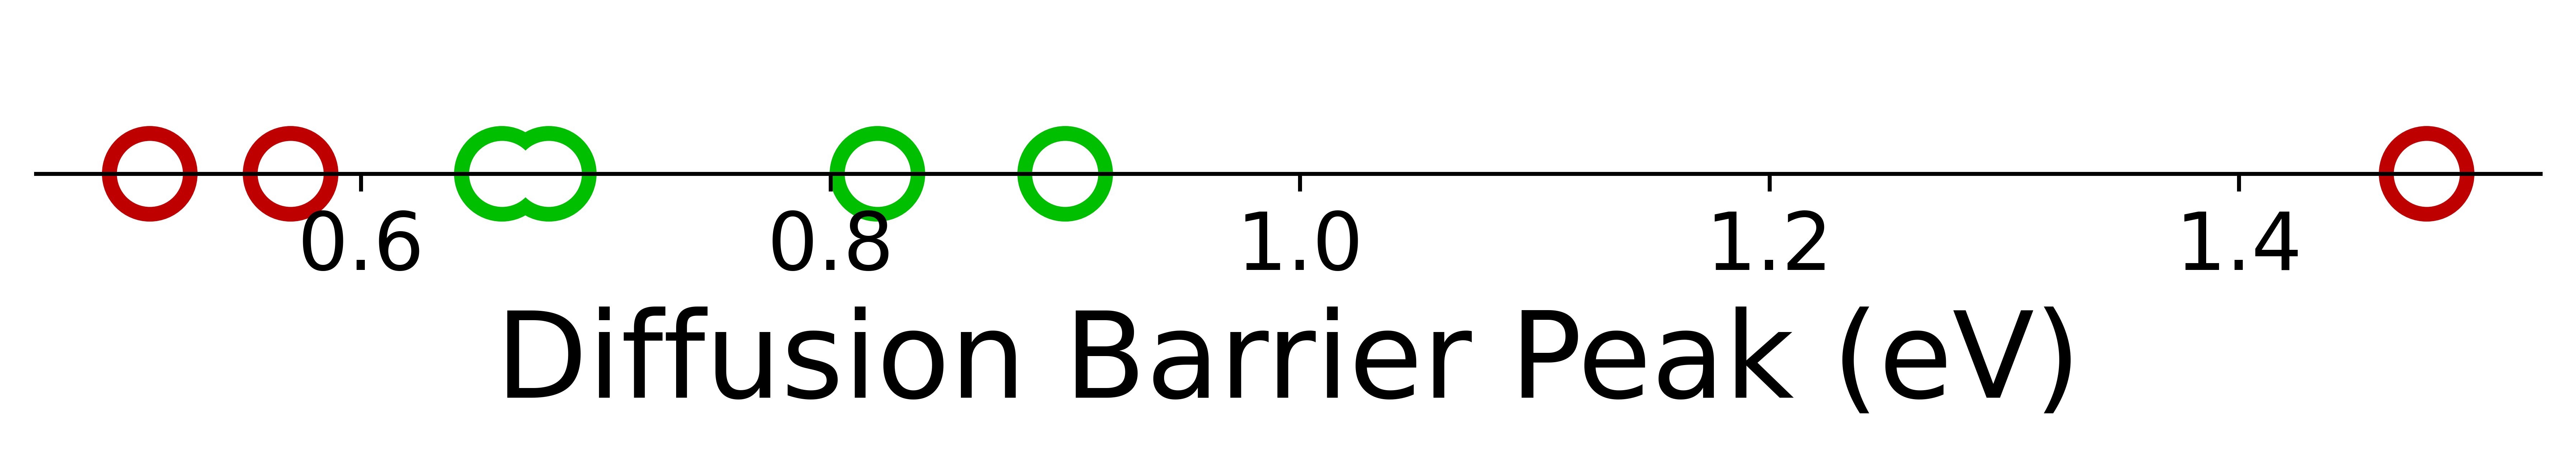

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(9, 1), dpi = 1000)
ax = fig.add_subplot(1, 1, 1)

ax.spines['bottom'].set_position('center')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.set_yticks([])


ax.scatter(data[1:10,3], np.zeros(9), color = colors_exp[1:10], marker = 'o', s = 330)
ax.scatter(data[1:10,3], np.zeros(9), color = mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)


ax.set_xlabel('Diffusion Barrier Peak (eV)', fontsize = 24)
plt.xticks(fontsize = 16) 

### Progression of Logistic Regression

(-1.0, 9.0)

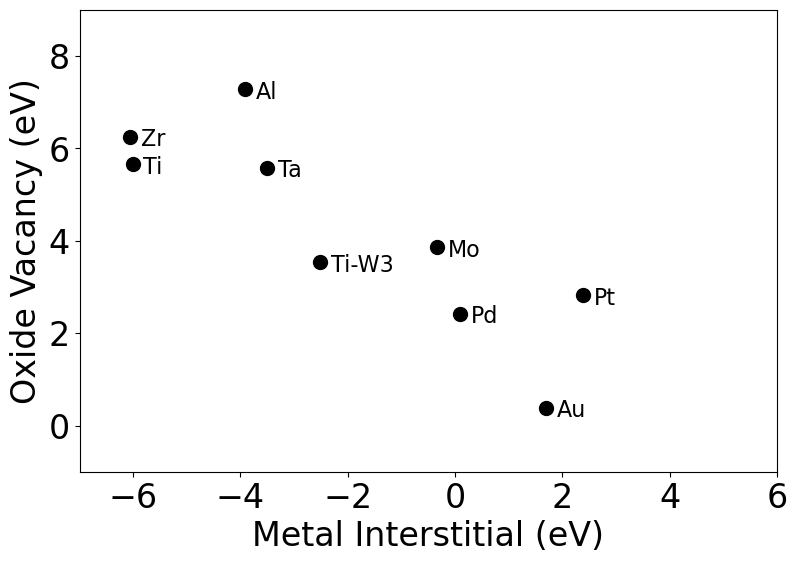

In [5]:
# Initial Calculated Metals
metals_calc_1 = np.array(['Ta', 'Mo', 'W', 'Al', 'Au', 'Pd', 'Pt', 'Zr', 'Ti', 'Ti-W3'])
metals_calc_1_ind_bool = np.isin(metals, metals_calc_1)

plt.figure(figsize=(9, 6))

plt.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  mpl.colors.to_hex((0,0,0)), marker = 'o', s = 100)

plt.xlabel('Metal Interstitial (eV)', fontsize = fs)
plt.ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs) 

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        plt.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)


plt.xlim(-7,6)
plt.ylim(-1,9)


(-1.0, 9.0)

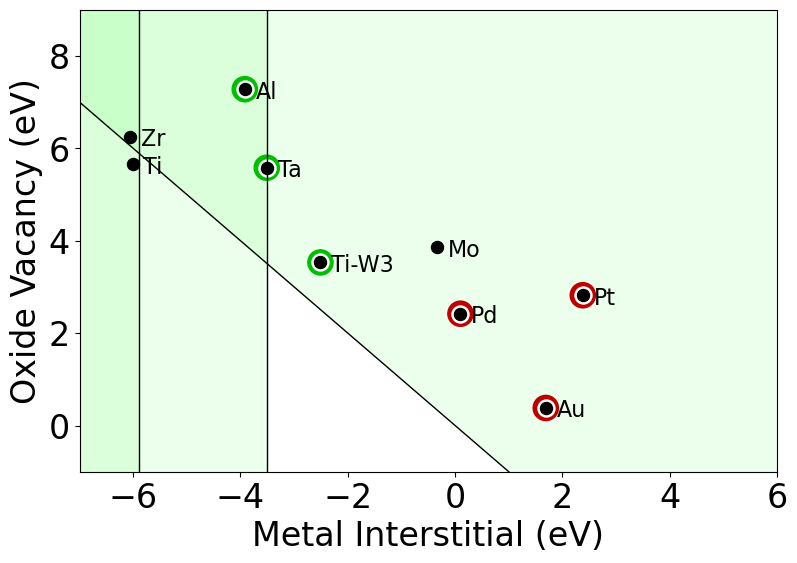

In [6]:
# Initial Metals Tested Experimentally
metals_exp_1 = np.array(['Ta', 'Pd', 'Pt', 'Au', 'Ti-W3', 'Al'])
metals_exp_1_ind_bool = np.isin(metals, metals_exp_1)

plt.figure(figsize=(9, 6))

# Regions of favorable thermodynamic barrier
plt.plot([-10,10], [10,-10], color='k', linewidth = 1)
plt.fill_between([-10,10], [10,-10], 10, interpolate=True, color = (0,1,0,alpha))

plt.plot([mi[0], mi[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], mi[0], -10, color = (0,1,0,alpha))

plt.plot([-of[0], -of[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], -of[0], -10, color = (0,1,0,alpha))

# Metals where extra outer circle means experimental verification
plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
plt.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  mpl.colors.to_hex((0,0,0)), marker = 'o', s = 75)

plt.xlabel('Metal Interstitial (eV)', fontsize = fs)
plt.ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs) 

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        plt.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)

plt.xlim(-7,6)
plt.ylim(-1,9)

(-1.0, 9.0)

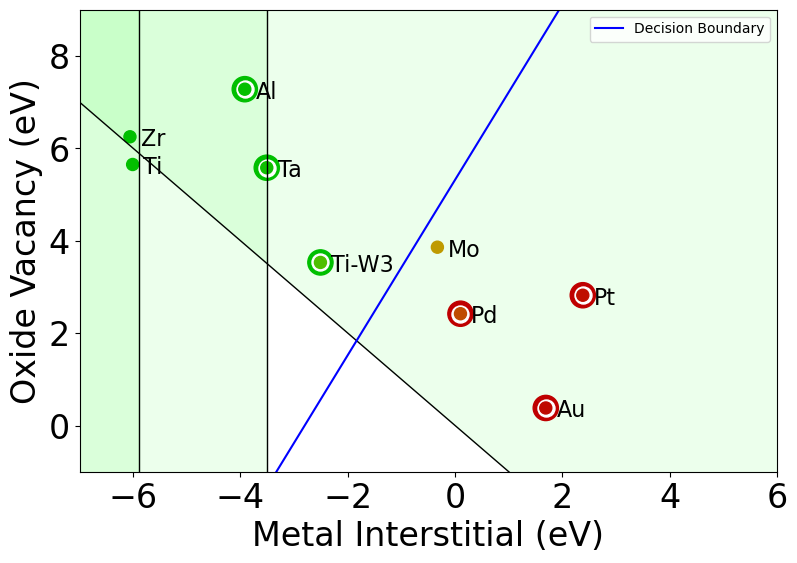

In [7]:
# Logistic Regression Training Arrays
mi_exp = np.array([])
of_exp = np.array([])
decision_exp = np.array([])

# fills in training array with experimentally verified metals
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    mi_exp = np.append(mi_exp, mi[ind])
    of_exp = np.append(of_exp, of[ind])
    decision_exp = np.append(decision_exp, data[ind,0])

# Logistic Regression
X = np.vstack((mi_exp,of_exp)).T
Y = decision_exp
lr = sklearn.linear_model.LogisticRegression(class_weight = 'balanced')
lr.fit(X,Y)
preds = lr.predict_proba(np.vstack((mi,of)).T)
probs = preds[:,1]

# Decision Boundary Line Parameters
b = lr.intercept_[0]
w1, w2 = lr.coef_.T
c = -b/w2
m = -w1/w2

xline = np.linspace(-7, 6, 100)
yline = m*xline + c

# colors for predictions
colors_pred = np.array([mpl.colors.to_hex(c) for c in custom_cmap(probs)])

# colors for experimentally verified metals
colors_exp_1 = colors_pred.copy()
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    colors_exp_1[ind] = colors_exp[ind]

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot([-10,10], [10,-10], color='k', linewidth = 1)
ax.fill_between([-10,10], [10,-10], 10, interpolate=True, color = (0,1,0,alpha))

ax.plot([mi[0], mi[0]], [-10, 10], color = 'k', linewidth = 1)
ax.fill_betweenx([-10, 10], mi[0], -10, color = (0,1,0,alpha))

ax.plot([-of[0], -of[0]], [-10, 10], color = 'k', linewidth = 1)
ax.fill_betweenx([-10, 10], -of[0], -10, color = (0,1,0,alpha))

ax.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
ax.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
ax.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  colors_pred[metals_calc_1_ind_bool], marker = 'o', s = 75)

# Decision Boundary
ax.plot(xline, yline, color='b', label='Decision Boundary')

ax.set_xlabel('Metal Interstitial (eV)', fontsize = fs)
ax.set_ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs)

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        ax.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)

plt.legend()

plt.xlim(-7,6)
plt.ylim(-1,9)

[0.6329153]


(-1.0, 9.0)

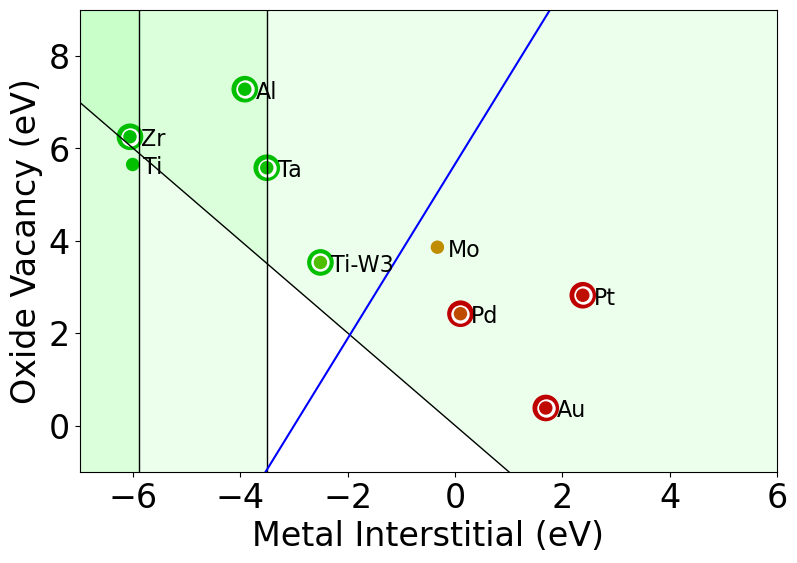

In [8]:
# tested Zr and W
metals_exp_1 = np.array(['Ta', 'Pd', 'Pt', 'Au', 'Ti-W3', 'Al', 'Zr', 'W'])
metals_exp_1_ind_bool = np.isin(metals, metals_exp_1)

# remaining is same code as above
mi_exp = np.array([])
of_exp = np.array([])
decision_exp = np.array([])
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    mi_exp = np.append(mi_exp, mi[ind])
    of_exp = np.append(of_exp, of[ind])
    decision_exp = np.append(decision_exp, data[ind,0])

X = np.vstack((mi_exp,of_exp)).T
Y = decision_exp
lr = sklearn.linear_model.LogisticRegression(class_weight = 'balanced')
lr.fit(X,Y)
preds = lr.predict_proba(np.vstack((mi,of)).T)
probs = preds[:,1]

b = lr.intercept_[0]
w1, w2 = lr.coef_.T
c = -b/w2
m = -w1/w2

xline = np.linspace(-7, 6, 100)
yline = m*xline + c

for metal in metals:
    if metal not in metals_exp_1:
        ind = np.where(metals == metal)
        colors_pred[ind] = mpl.colors.to_hex(custom_cmap(probs[ind]))

colors_exp_1 = colors_pred.copy()
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    colors_exp_1[ind] = colors_exp[ind]

print(probs[metals == 'Mo'])

plt.figure(figsize=(9, 6))

plt.plot([-10,10], [10,-10], color='k', linewidth = 1)
plt.fill_between([-10,10], [10,-10], 10, interpolate=True, color = (0,1,0,alpha))

plt.plot([mi[0], mi[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], mi[0], -10, color = (0,1,0,alpha))

plt.plot([-of[0], -of[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], -of[0], -10, color = (0,1,0,alpha))

plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
plt.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  colors_pred[metals_calc_1_ind_bool], marker = 'o', s = 75)

plt.plot(xline, yline, color='b')


plt.xlabel('Metal Interstitial (eV)', fontsize = fs)
plt.ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs) 

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        plt.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)


plt.xlim(-7,6)
plt.ylim(-1,9)

(-1.0, 9.0)

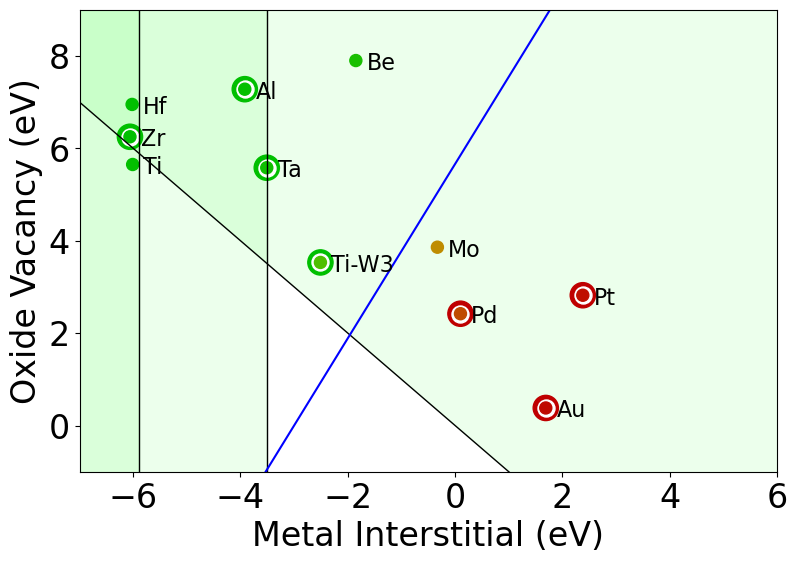

In [9]:
# Calculated Be and Hf
metals_calc_1 = np.array(['Ta', 'Mo', 'W', 'Al', 'Au', 'Pd', 'Pt', 'Zr', 'Ti', 'Ti-W3', 'Be', 'Hf'])
metals_calc_1_ind_bool = np.isin(metals, metals_calc_1)

plt.figure(figsize=(9, 6))

plt.plot([-10,10], [10,-10], color='k', linewidth = 1)
plt.fill_between([-10,10], [10,-10], 10, interpolate=True, color = (0,1,0,alpha))

plt.plot([mi[0], mi[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], mi[0], -10, color = (0,1,0,alpha))

plt.plot([-of[0], -of[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], -of[0], -10, color = (0,1,0,alpha))

plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
plt.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  colors_pred[metals_calc_1_ind_bool], marker = 'o', s = 75)

plt.plot(xline, yline, color='b')

plt.xlabel('Metal Interstitial (eV)', fontsize = fs)
plt.ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs) 

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        plt.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)


plt.xlim(-7,6)
plt.ylim(-1,9)

[0.68537631]


(-1.0, 9.0)

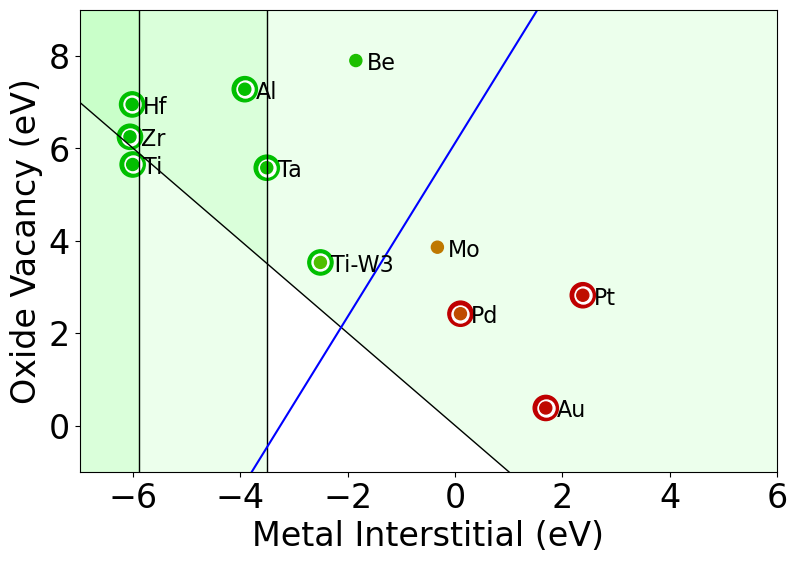

In [10]:
# tested Ti and Hf
metals_exp_1 = np.array(['Ta', 'Pd', 'Pt', 'Au', 'Ti-W3', 'Al', 'Zr', 'W', 'Ti', 'Hf'])
metals_exp_1_ind_bool = np.isin(metals, metals_exp_1)

mi_exp = np.array([])
of_exp = np.array([])
decision_exp = np.array([])
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    mi_exp = np.append(mi_exp, mi[ind])
    of_exp = np.append(of_exp, of[ind])
    decision_exp = np.append(decision_exp, data[ind,0])

X = np.vstack((mi_exp,of_exp)).T
Y = decision_exp
lr = sklearn.linear_model.LogisticRegression(class_weight = 'balanced')
lr.fit(X,Y)
preds = lr.predict_proba(np.vstack((mi,of)).T)
probs = preds[:,1]

b = lr.intercept_[0]
w1, w2 = lr.coef_.T
c = -b/w2
m = -w1/w2

xline = np.linspace(-7, 6, 100)
yline = m*xline + c

for metal in metals:
    if metal not in metals_exp_1:
        ind = np.where(metals == metal)
        colors_pred[ind] = mpl.colors.to_hex(custom_cmap(probs[ind]))

colors_exp_1 = colors_pred.copy()
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    colors_exp_1[ind] = colors_exp[ind]

print(probs[metals == 'Mo'])

plt.figure(figsize=(9, 6))

plt.plot([-10,10], [10,-10], color='k', linewidth = 1)
plt.fill_between([-10,10], [10,-10], 10, interpolate=True, color = (0,1,0,alpha))

plt.plot([mi[0], mi[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], mi[0], -10, color = (0,1,0,alpha))

plt.plot([-of[0], -of[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], -of[0], -10, color = (0,1,0,alpha))

plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
plt.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  colors_pred[metals_calc_1_ind_bool], marker = 'o', s = 75)

plt.plot(xline, yline, color='b')

plt.xlabel('Metal Interstitial (eV)', fontsize = fs)
plt.ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs) 

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        plt.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)


plt.xlim(-7,6)
plt.ylim(-1,9)

(-1.0, 9.0)

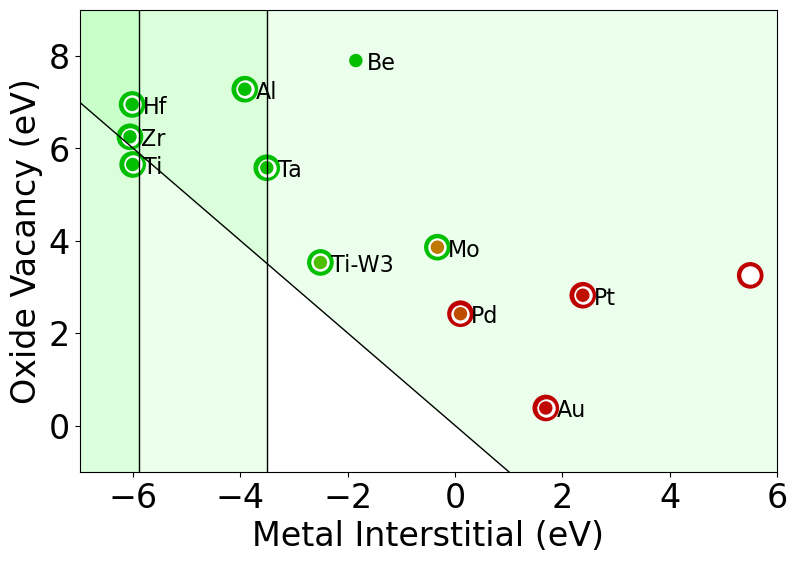

In [11]:
# Tested Mo and Ir
metals_exp_1 = np.array(['Ta', 'Pd', 'Pt', 'Au', 'Ti-W3', 'Al', 'Zr', 'W', 'Ti', 'Hf', 'Mo', 'Ir'])
metals_exp_1_ind_bool = np.isin(metals, metals_exp_1)

mi_exp = np.array([])
of_exp = np.array([])
decision_exp = np.array([])
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    mi_exp = np.append(mi_exp, mi[ind])
    of_exp = np.append(of_exp, of[ind])
    decision_exp = np.append(decision_exp, data[ind,0])

X = np.vstack((mi_exp,of_exp)).T
Y = decision_exp
lr = sklearn.linear_model.LogisticRegression(class_weight = 'balanced')
lr.fit(X,Y)
preds = lr.predict_proba(np.vstack((mi,of)).T)
probs = preds[:,1]

b = lr.intercept_[0]
w1, w2 = lr.coef_.T
c = -b/w2
m = -w1/w2

xline = np.linspace(-7, 6, 100)
yline = m*xline + c

for metal in metals:
    if metal not in metals_exp_1:
        ind = np.where(metals == metal)
        colors_pred[ind] = mpl.colors.to_hex(custom_cmap(probs[ind]))

# colors_pred = np.array([mpl.colors.to_hex(c) for c in custom_cmap(probs)])

colors_exp_1 = colors_pred.copy()
for metal in metals_exp_1:
    ind = np.where(metals == metal)
    colors_exp_1[ind] = colors_exp[ind]
# print(colors_exp_1)

plt.figure(figsize=(9, 6))

plt.plot([-10,10], [10,-10], color='k', linewidth = 1)
plt.fill_between([-10,10], [10,-10], 10, interpolate=True, color = (0,1,0,alpha))
# # plt.fill_between([-10,10], [10,-10], -10, interpolate=True, color = (1,0,0,alpha))

plt.plot([mi[0], mi[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], mi[0], -10, color = (0,1,0,alpha))
# # plt.fill_betweenx([-10, 10], mi[0], 10, color = (1,0,0,alpha))

plt.plot([-of[0], -of[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], -of[0], -10, color = (0,1,0,alpha))
# # plt.fill_betweenx([-10, 10], -of[0], 10, color = (1,0,0,alpha))

plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
plt.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  colors_pred[metals_calc_1_ind_bool], marker = 'o', s = 75)

# plt.plot(xline, yline, color='b')

# plt.scatter(mi[np.logical_and(structuren == 1, metals_calc_1_ind_bool)], of[np.logical_and(structuren == 1, metals_calc_1_ind_bool)], color = colors_exp_1[np.logical_and(structuren == 1, metals_calc_1_ind_bool)], marker = 's', s = 100)
# plt.scatter(mi[np.logical_and(structure == 'fcc', metals_calc_1_ind_bool)], of[np.logical_and(structure == 'fcc', metals_calc_1_ind_bool)], color = colors_exp_1[np.logical_and(structure == 'fcc', metals_calc_1_ind_bool)], marker = '^', s = 100)
# plt.scatter(mi[np.logical_and(structure == 'hcp', metals_calc_1_ind_bool)], of[np.logical_and(structure == 'hcp', metals_calc_1_ind_bool)], color = colors_exp_1[np.logical_and(structure == 'hcp', metals_calc_1_ind_bool)], marker = 'h', s = 100)

plt.xlabel('Metal Interstitial (eV)', fontsize = fs)
plt.ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs) 

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        plt.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)


plt.xlim(-7,6)
plt.ylim(-1,9)

### Formation Energy Plot

(array([-7., -6., -5., -4., -3., -2., -1.,  0.]),
 [Text(-7.0, 0, '−7'),
  Text(-6.0, 0, '−6'),
  Text(-5.0, 0, '−5'),
  Text(-4.0, 0, '−4'),
  Text(-3.0, 0, '−3'),
  Text(-2.0, 0, '−2'),
  Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0')])

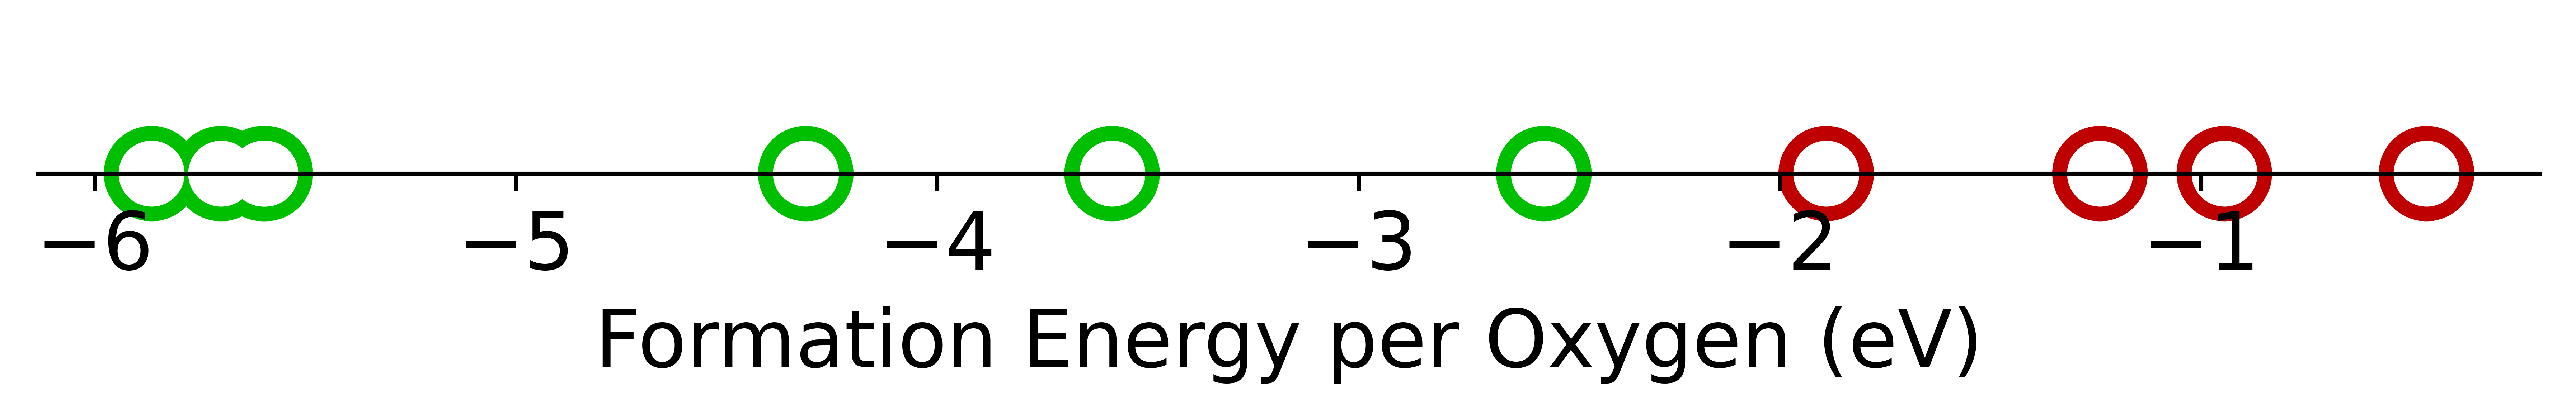

In [12]:

fig = plt.figure(figsize=(9, 1), dpi=1000)
ax = fig.add_subplot(1, 1, 1)

ax.spines['bottom'].set_position('center')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.set_yticks([])

ax.scatter(fe[metals_exp_1_ind_bool], np.zeros(len(fe[metals_exp_1_ind_bool])), color = colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
ax.scatter(fe[metals_exp_1_ind_bool], np.zeros(len(fe[metals_exp_1_ind_bool])), color = mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)

ax.set_xlabel('Formation Energy per Oxygen (eV)', fontsize = 16)
plt.xticks(fontsize = 16) 

### 3D Plot of Formation Energy per Oxygen vs Oxide Vacancy Energy vs Metal Interstitial Energy

In [13]:
# Defining Plane
def plane(x, a, b, c):
    return a*x[0,:] + b*x[1,:] + c

[ 0.2137425  -0.64960913 -0.69059224]
[0.05528946 0.09369266 0.36126267]
0.5543958987716846


Text(0.5, 0, 'Oxide Formation\nEnergy (eV)')

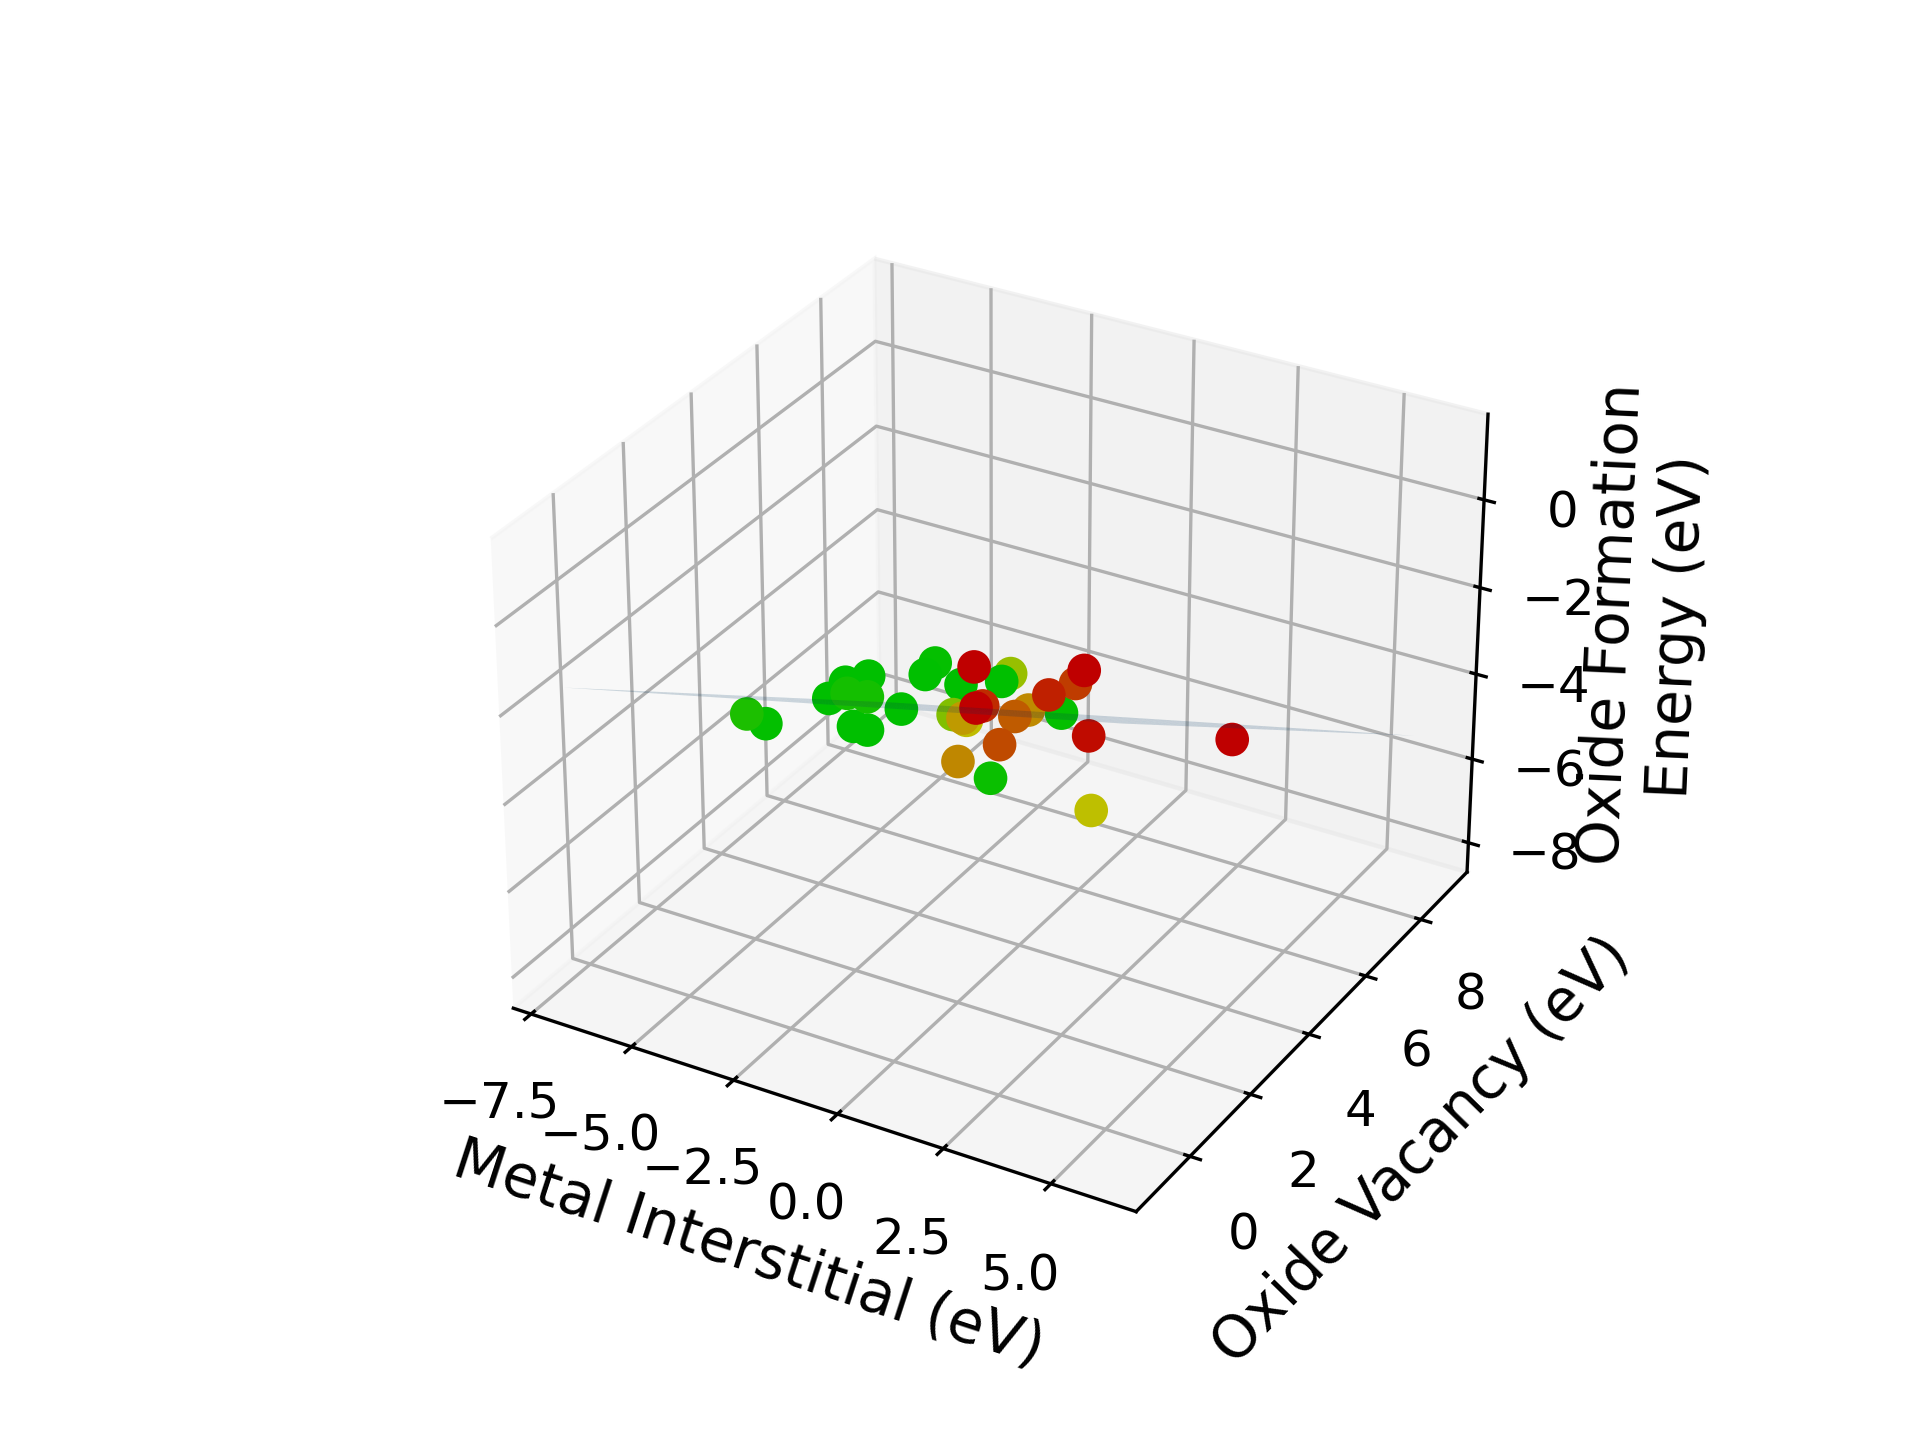

In [14]:
%matplotlib ipympl

# Finding plane of best fit
X = np.vstack((mi, of))
Y = fe

popt, pcov = sp.curve_fit(plane, X, Y)
p_sigma = np.sqrt(np.diag(pcov))

# calculating R^2
residuals = Y - plane(X, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((Y - np.mean(Y))**2)

r_squared = 1 - (ss_res / ss_tot)
# print(r_squared)

print(popt)
print(p_sigma)

# Calculating mean absolute error
mae = np.mean(np.abs(Y - plane(X, *popt)))
print(mae)


fig = plt.figure(dpi=300)
ax = fig.add_subplot(projection='3d')

xplane, yplane = np.meshgrid(np.linspace(-7, 6, 100), np.linspace(-1, 9, 100))
xyplane = np.array([xplane, yplane])

ax.plot_surface(xplane, yplane, plane(xyplane, *popt), alpha=0.2)

ax.scatter(mi, of, fe, color=colors_exp_1, s=50, depthshade=False)


fontsize = 12

ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.tick_params(axis='z', labelsize=fontsize)
ax.set_xlabel('Metal Interstitial (eV)', fontsize = 14)
ax.set_ylabel('Oxide Vacancy (eV)', fontsize = 14)
ax.set_zlabel('Oxide Formation\nEnergy (eV)', fontsize = 14)




In [ ]:
# Logistic Regression with fixed slope (for determining position of dashed line in Figure 3b)

def fit_intercept_fixed_slope(X, y_labels, slope):
    x = X[:, 0]
    y = X[:, 1]
    
    # Compute class weights: inverse frequency
    w_pos = 1.0 / np.sum(y_labels == 1)
    w_neg = 1.0 / np.sum(y_labels == 0)
    weights = np.where(y_labels == 1, w_pos, w_neg)

    def logistic_loss(b):
        z = y - slope * x - b
        p = expit(z)
        eps = 1e-10
        return -np.sum(weights * (y_labels * np.log(p + eps) + (1 - y_labels) * np.log(1 - p + eps)))
    
    res = minimize(logistic_loss, x0=[0.0], method='BFGS')
    return res.x[0]

[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.]
2.4630195622087028
3.6899500440895743


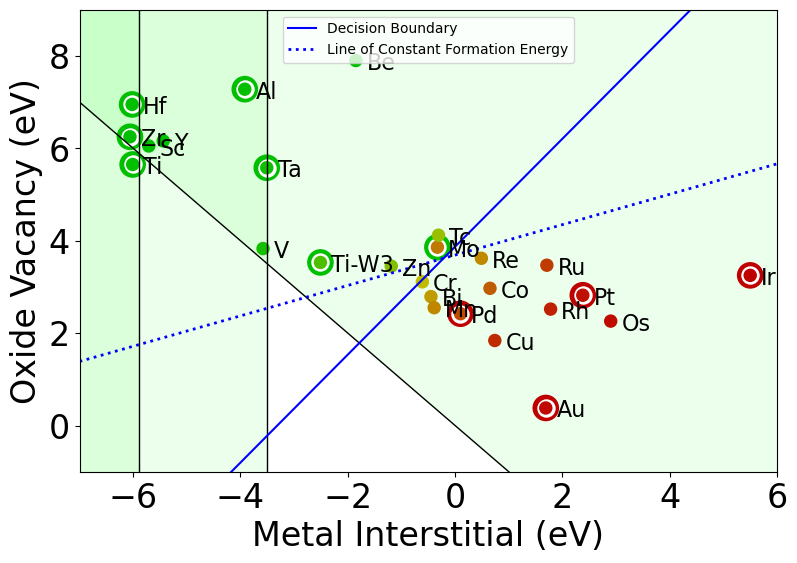

In [18]:
%matplotlib inline

# calculated V, Cr, Ir, Co, Rh, Sc, Y, Re, Tc, Bi, Ru, Cu, Mn, Os, and Zn
metals_calc_1 = np.array(['Ta', 'Mo', 'W', 'Al', 'Au', 'Pd', 'Pt', 'Zr', 'Ti', 'Ti-W3', 'Be', 'Hf', 'V', 'Cr', 'Ir', 'Co', 'Rh', 'Sc', 'Y', 'Re', 'Tc', 'Bi', 'Ru', 'Cu', 'Mn', 'Os', 'Zn'])
metals_calc_1_ind_bool = np.isin(metals, metals_calc_1)

plt.figure(figsize=(9, 6))

plt.plot([-10,10], [10,-10], color='k', linewidth = 1)
plt.fill_between([-10,10], [10,-10], 10, interpolate=True, color = (0,1,0,alpha))

plt.plot([mi[0], mi[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], mi[0], -10, color = (0,1,0,alpha))

plt.plot([-of[0], -of[0]], [-10, 10], color = 'k', linewidth = 1)
plt.fill_betweenx([-10, 10], -of[0], -10, color = (0,1,0,alpha))

plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  colors_exp[metals_exp_1_ind_bool], marker = 'o', s = 330)
plt.scatter(mi[metals_exp_1_ind_bool], of[metals_exp_1_ind_bool], color =  mpl.colors.to_hex((1,1,1)), marker = 'o', s = 150)
plt.scatter(mi[metals_calc_1_ind_bool], of[metals_calc_1_ind_bool], color =  colors_pred[metals_calc_1_ind_bool], marker = 'o', s = 75)

plt.plot(xline, yline, color='b', label='Decision Boundary')




## Logistic Regression for dashed line position
a, b, c = popt
x1_grid = np.linspace(-7, 6, 200)
X = np.vstack((mi_exp,of_exp)).T
Y = decision_exp
b_opt = fit_intercept_fixed_slope(X, Y, -a/b)
print(Y)
print(-1.6/b)
print(b_opt)
x2_other = -a/b * x1_grid + b_opt
plt.plot(x1_grid, x2_other, color='blue', linestyle=':', linewidth=2, label='Line of Constant Formation Energy')


plt.xlabel('Metal Interstitial (eV)', fontsize = fs)
plt.ylabel('Oxide Vacancy (eV)', fontsize = fs)
plt.xticks(fontsize = fs) 
plt.yticks(fontsize = fs) 

for i, txt in enumerate(metals):
    if metals_calc_1_ind_bool[i]:
        plt.annotate(txt, (mi[i], of[i]), xytext = (mi[i]+0.2, of[i]-0.2), fontsize = fs2)


plt.xlim(-7,6)
plt.ylim(-1,9)

plt.legend()